In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
from random import choices
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout

In [2]:
import zipfile

input_path = '/content/brain_images_dataset (1).zip'
extracted_path = '/content/extracted_files'

# Create a directory to extract the files
os.makedirs(extracted_path, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(input_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Iterate through the extracted files
for file in os.listdir(extracted_path):
    print(file)


yes
no


<Axes: >

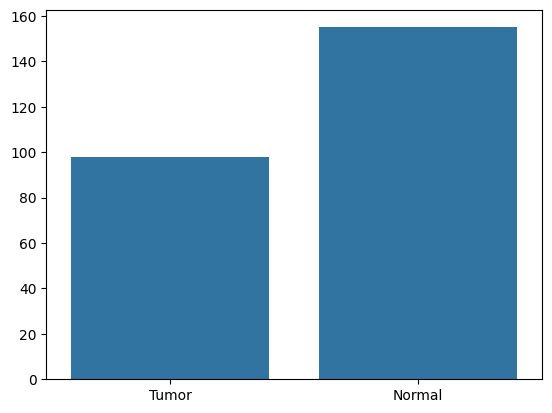

In [3]:
type1=len(os.listdir(extracted_path+'/no'))
type2=len(os.listdir(extracted_path+'/yes'))

count=[type1,type2]
label=['Tumor','Normal']

sns.barplot(x=label,y=count)

In [4]:
def show_image(folder):
    path=os.path.join(extracted_path,folder)

    images=choices(os.listdir(path),k=4)
    images=[os.path.join(path,file) for file in images]

    return images

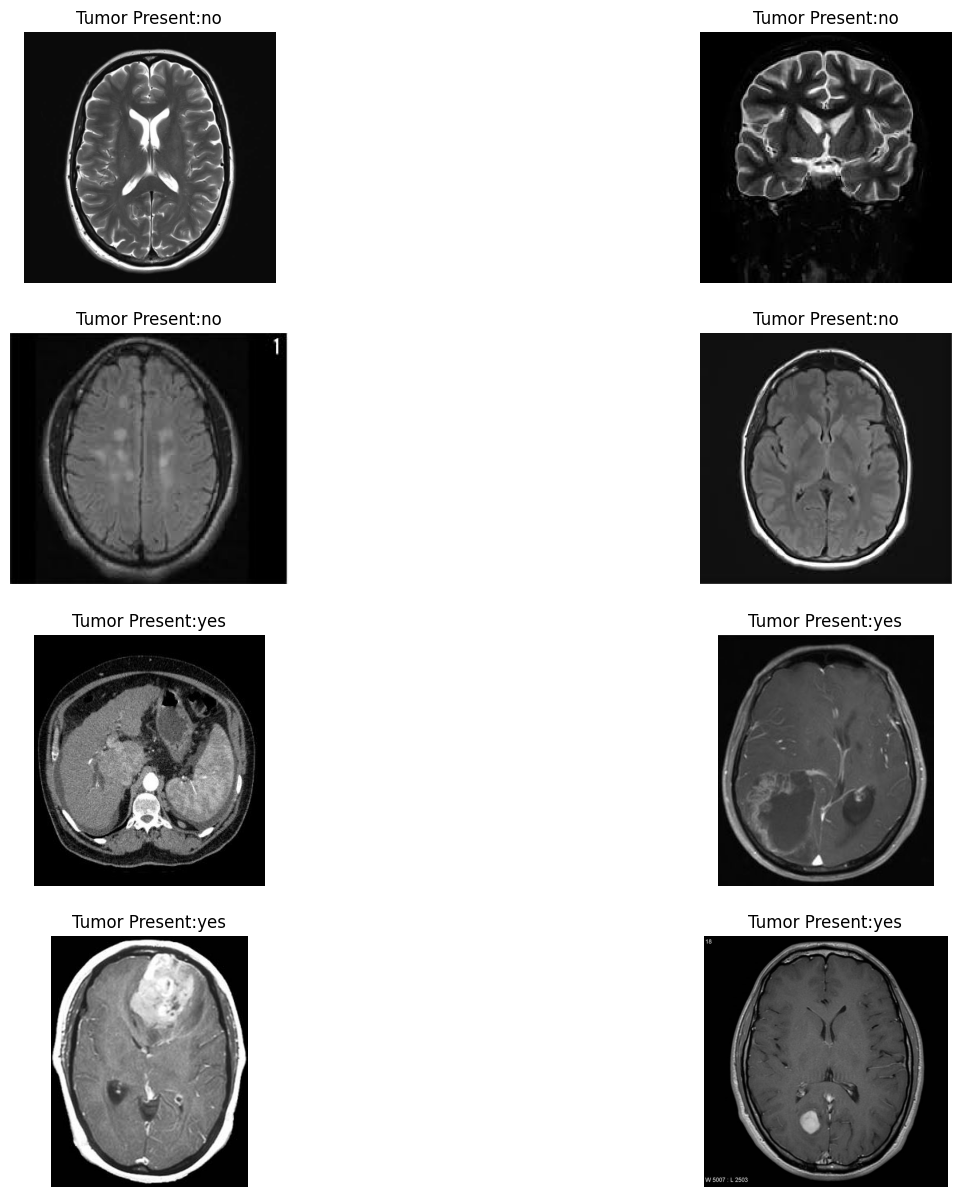

In [5]:
img1=show_image('no')
img2=show_image('yes')
label1=['no']*4
label2=['yes']*4

images=img1+img2
labels=label1+label2

plt.figure(figsize=(16,15))

for i,path_name in enumerate(images):
    plt.subplot(4,2,i+1)
    image=cv.imread(path_name)
    plt.imshow(image)
    plt.title("Tumor Present:"+labels[i])
    plt.axis('off')

In [6]:
datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5],
                             validation_split=0.2
                            )

train_gen= datagen.flow_from_directory(extracted_path,
                                       target_size=(240,240),
                                       class_mode='binary',
                                       subset='training'
                                      )
val_gen = datagen.flow_from_directory( extracted_path,
                                       target_size=(240,240),
                                       class_mode='binary',
                                       subset='validation'
                                      )

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [7]:
vgg_model=VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)

In [8]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), input_shape=(240, 240, 3), activation='relu',padding='same', name='conv2d_8'))

# Max pooling layer 1
model.add(MaxPooling2D(pool_size=(4, 4), name='max_pooling2d_20'))

# Max pooling layer 2
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_21'))

# Max pooling layer 3
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_22'))

# Flatten layer
model.add(Flatten(name='flatten_7'))

# Dense layer 1
model.add(Dense(256, activation='relu', name='dense_14'))

# Dense layer 2 (final output)
model.add(Dense(1, activation='sigmoid', name='dense_15'))

# Display the model summary
model.summary()
print("Output shape after Dense_2 (final output):", model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 240, 240, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 60, 60, 32)        0         
 ng2D)                                                           
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 7200)              0         
                                                        

In [9]:
from tensorflow.keras.metrics import Recall
model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=[Recall(), 'accuracy'])

In [10]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history=model.fit(train_gen,validation_data=val_gen,epochs=30,callbacks=[stop,checkpoint])

Epoch 1/30
7/7 [==============================] - 15s 2s/step - loss: 2.3241 - recall: 0.3548 - accuracy: 0.4532 - val_loss: 0.6874 - val_recall: 0.8065 - val_accuracy: 0.6400
Epoch 2/30
7/7 [==============================] - 13s 2s/step - loss: 0.6615 - recall: 0.9677 - accuracy: 0.6305 - val_loss: 0.5451 - val_recall: 0.8065 - val_accuracy: 0.7400
Epoch 3/30
7/7 [==============================] - 12s 2s/step - loss: 0.5753 - recall: 0.8629 - accuracy: 0.7340 - val_loss: 0.4777 - val_recall: 0.7742 - val_accuracy: 0.7400
Epoch 4/30
7/7 [==============================] - 13s 2s/step - loss: 0.5756 - recall: 0.8952 - accuracy: 0.7192 - val_loss: 0.5325 - val_recall: 1.0000 - val_accuracy: 0.6800
Epoch 5/30
7/7 [==============================] - 12s 2s/step - loss: 0.6025 - recall: 0.9839 - accuracy: 0.7044 - val_loss: 0.5773 - val_recall: 0.8710 - val_accuracy: 0.6800
Epoch 6/30
7/7 [==============================] - 12s 2s/step - loss: 0.5388 - recall: 0.8710 - accuracy: 0.7882 - val_l

In [11]:
evaluation_result = model.evaluate(val_gen)

# Extract the recall score from the evaluation result
recall_score = evaluation_result[1]  # Index 1 corresponds to Recall in the metrics list

print(f'Test Recall: {recall_score * 100:.2f}%')

2/2 [==============================] - 1s 350ms/step - loss: 0.4756 - recall: 0.9032 - accuracy: 0.8000
Test Recall: 90.32%


In [13]:
#Model Performance

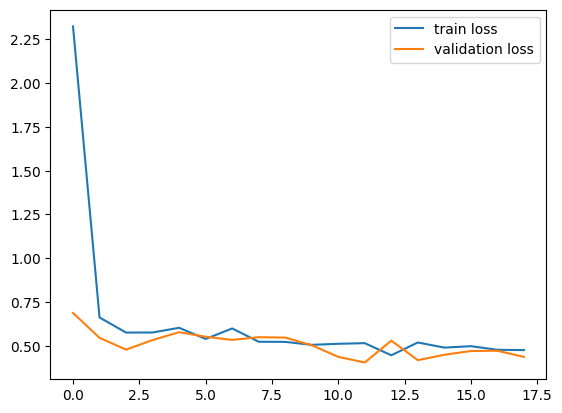

In [14]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

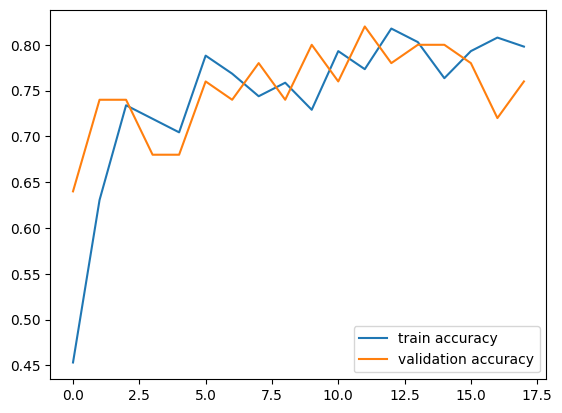

In [15]:
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

2/2 [==============================] - 3s 760ms/step


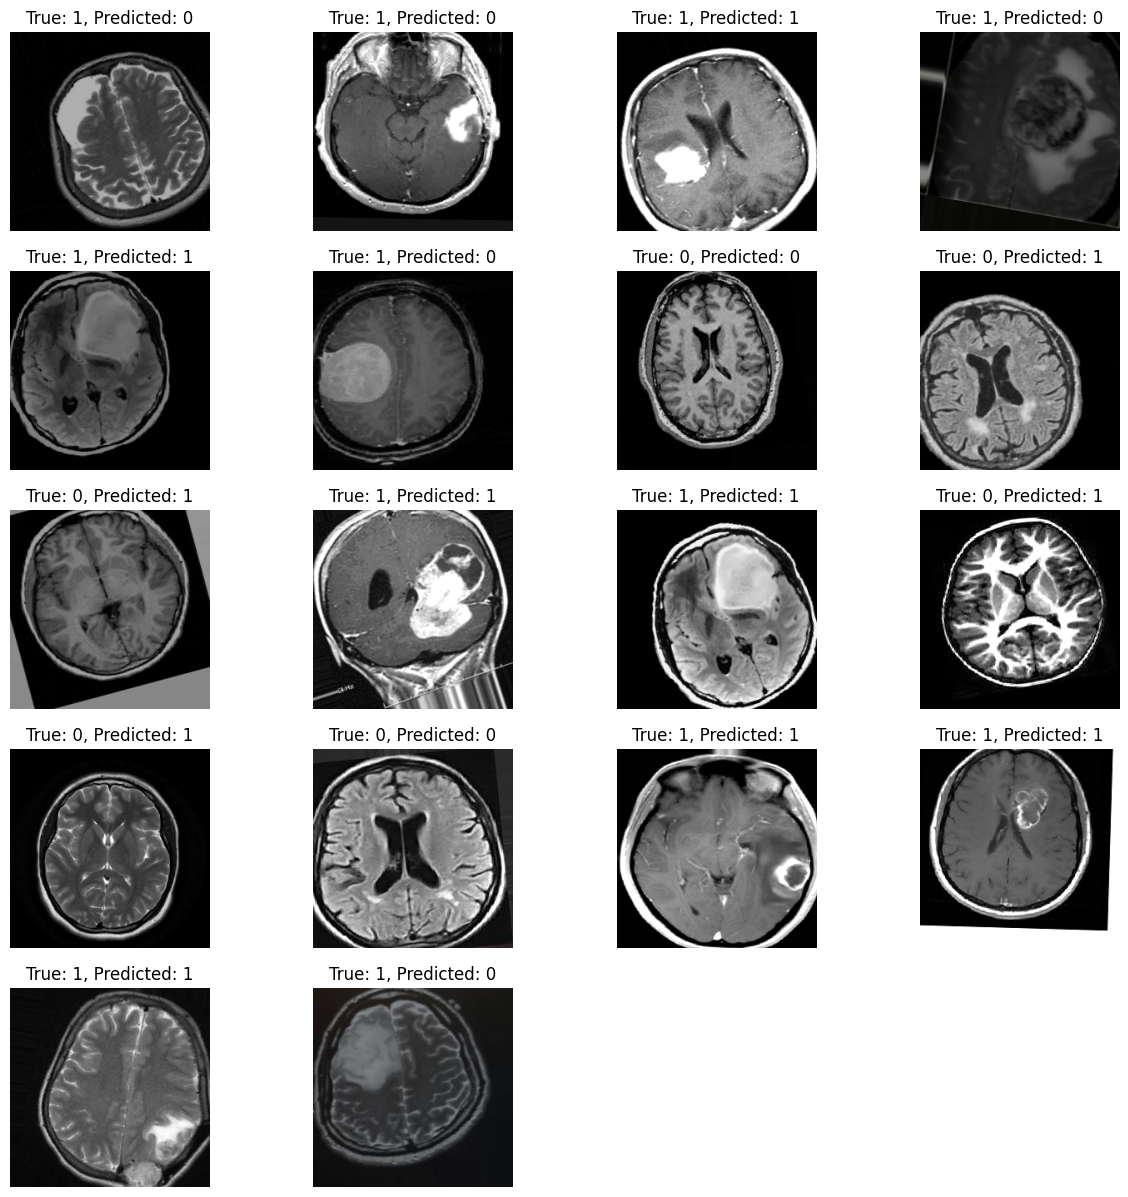

In [17]:
predictions = model.predict(val_gen)

val_images, val_labels = val_gen.next()

predicted_labels = np.round(predictions).flatten()
num_rows = int(np.ceil(len(val_labels) / 4))
num_cols = min(4, len(val_labels))
plt.figure(figsize=(15, 3 * num_rows))
for i in range(len(val_labels)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(val_images[i])
    plt.title(f'True: {int(val_labels[i])}, Predicted: {int(predicted_labels[i])}')
    plt.axis('off')

plt.show()